# Descriptive-Title
Felix Zaussinger | 11.11.2020

## Core Analysis Goal(s)
1. Auto-connect to our google sheets documents
    - https://docs.google.com/spreadsheets/d/1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc/edit#gid=370671396

2. Based on
    - https://towardsdatascience.com/how-to-access-google-sheet-data-using-the-python-api-and-convert-to-pandas-dataframe-5ec020564f0e
    - https://developers.google.com/sheets/api/quickstart/python.

## Key Insight(s)
1. It works.

2.

3.

In [16]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import print_function

import os
import pickle
import os.path
import numpy as np
import pandas as pd
from pathlib import Path

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

import seaborn as sns
sns.set_theme(
    context='talk', style='ticks', palette='Paired', font='sans-serif',
    font_scale=1.05, color_codes=True, rc=None
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Function

In [17]:
def get_google_sheet(spreadsheet_id, range_name, credentials):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)

    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                credentials, SCOPES)
            creds = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    try:
        # Call the Sheets API
        return service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    except HttpError:
        print("Sheet data could not be retrieved. Check if names really match.")
        return None


def gsheet2df(gsheet, header=0, stop=None):
    """ Converts Google sheet data to a Pandas DataFrame.
    Note: This script assumes that your data contains a header file on the first row!
    Also note that the Google API returns 'none' from empty cells - in order for the code
    below to work, you'll need to make sure your sheet doesn't contain empty cells,
    or update the code to account for such instances.
    """
    data_idx = header + 1
    header = gsheet.get('values', [])[header]   # Assumes first line is header!
    values = gsheet.get('values', [])[data_idx:stop]  # Everything else is data.
    n_vals = len(values)

    if not values:
        print('No data found.')
    else:
        all_data = []
        for col_id, col_name in enumerate(header):
            column_data = []

            for row in values:
                try:
                    s = row[col_id]
                except IndexError as msg:
                    s = np.nan
                column_data.append(s)
            ds = pd.Series(data=column_data, name=col_name)
            all_data.append(ds)
        df = pd.concat(all_data, axis=1)
        return df

#### Define paths

In [18]:
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")

#### Authentification

In [19]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# <Your spreadsheet ID>
SPREADSHEET_ID = "1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc"

# <Your worksheet names>
SHEETS = ["Farmer 1", "Farmer 2"]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Download

In [20]:
sheet_dict = {}

for i, sheet_name in enumerate(SHEETS):
    print(sheet_name)

    # 1) fetch data
    data_dict = get_google_sheet(
        credentials=credentials_fpath,
        spreadsheet_id=SPREADSHEET_ID,
        range_name=sheet_name
    )

    # 2) convert to data frame
    df_raw = gsheet2df(data_dict, header=0, stop=11)
    df_raw = df_raw.set_index("Round")

    # 3) convert to numeric
    df = df_raw.copy()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce", downcast="integer")

    # 4) append to dict
    sheet_dict[sheet_name] = df

Farmer 1
Farmer 2


In [21]:
df_all = pd.concat(sheet_dict.values(), keys=sheet_dict.keys())
df_all

Plot  Farmland (%)  Native forest (%)
         Round                                       
Farmer 1 1       NaN             0                  0
         2       NaN            40                -40
         3       NaN            60                -60
         4       NaN             0                  0
         5       NaN             0                  0
         6       NaN           -80                 80
         7       NaN             0                  0
         8       NaN             0                  0
         9       NaN            40                -40
         10      NaN             0                  0
Farmer 2 1       NaN            20                -20
         2       NaN           -40                 40
         3       NaN             0                  0
         4       NaN             0                  0
         5       NaN            60                -60
         6       NaN             0                  0
         7       NaN            20                -20
         8       NaN             0                  0
         9       NaN             0                  0
         10      NaN             0                  0

In [22]:
df_all.index = df_all.index.set_names(["player", "round"])
df_all = df_all.reset_index()
df_all["round"] = pd.to_numeric(df_all["round"], errors="coerce", downcast="integer")

In [23]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             20 non-null     object 
 1   round              20 non-null     int8   
 2   Plot               0 non-null      float64
 3   Farmland (%)       20 non-null     int8   
 4   Native forest (%)  20 non-null     int8   
dtypes: float64(1), int8(3), object(1)
memory usage: 508.0+ bytes


In [24]:
df_final = df_all.set_index(["round", "player"]).sort_index()

# https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index
df_final = df_final.unstack(level="player")
df_final

Plot          Farmland (%)          Native forest (%)         
player Farmer 1 Farmer 2     Farmer 1 Farmer 2          Farmer 1 Farmer 2
round                                                                    
1           NaN      NaN            0       20                 0      -20
2           NaN      NaN           40      -40               -40       40
3           NaN      NaN           60        0               -60        0
4           NaN      NaN            0        0                 0        0
5           NaN      NaN            0       60                 0      -60
6           NaN      NaN          -80        0                80        0
7           NaN      NaN            0       20                 0      -20
8           NaN      NaN            0        0                 0        0
9           NaN      NaN           40        0               -40        0
10          NaN      NaN            0        0                 0        0

(0.0, 100.0)

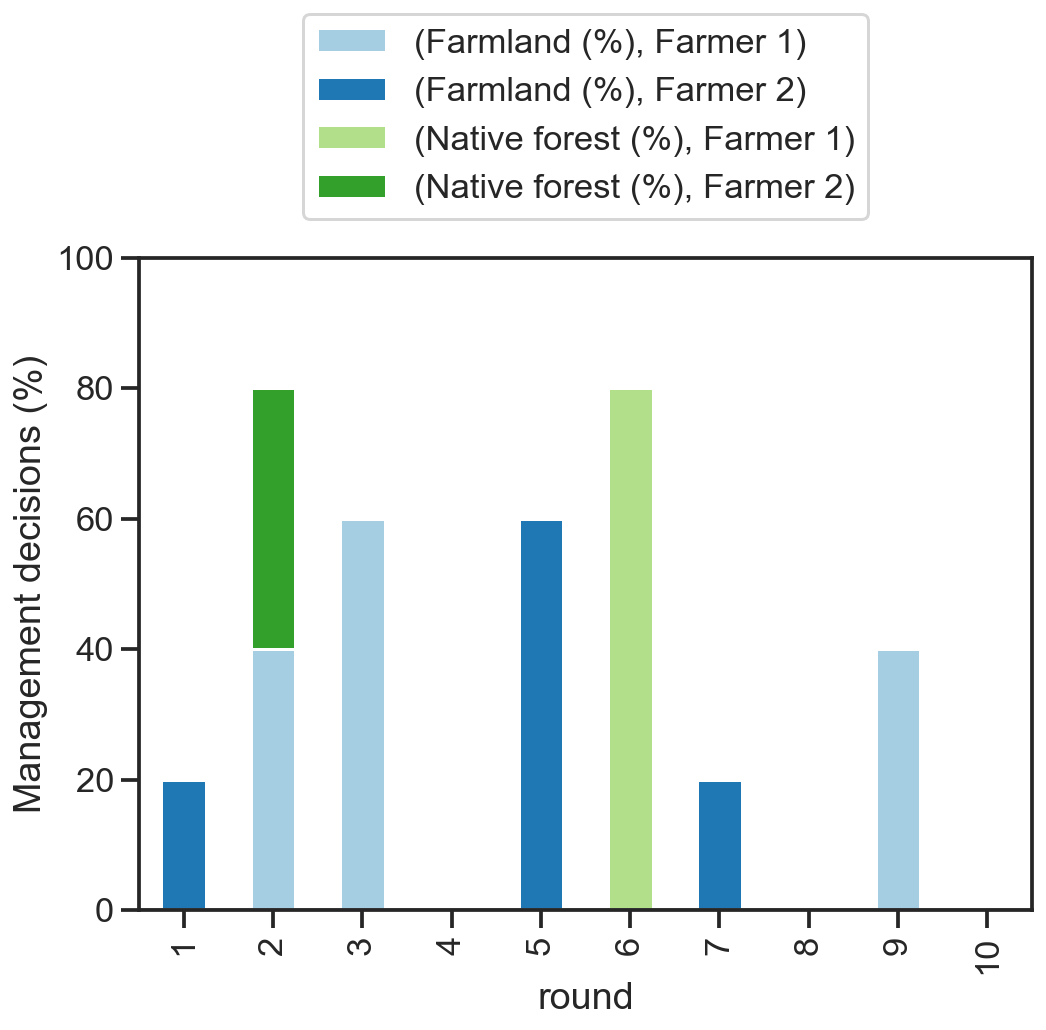

In [25]:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

decisions = df_final[["Farmland (%)", "Native forest (%)"]]

# plot decisions
ax = decisions.plot(kind='bar', stacked=True, figsize=(10,6))

# Shrink current axis by 20% & put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))

# labels
ax.set_ylabel("Management decisions (%)")
ax.axhline(linestyle="-", color="grey")
ax.set_ylim(0, 100)
